FileNotFoundError: [Errno 2] No such file or directory: 'out/disability/pickups-per-vehicle-10pop-1fleet-v3.png'

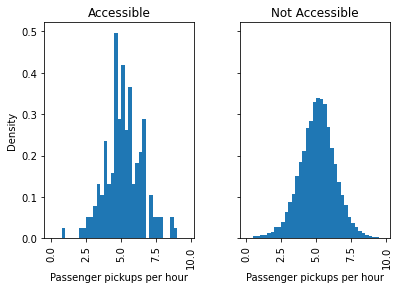

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import contextily as ctx

taz = gpd.read_file('C:/Users/nrezaei/Documents/Data/sfbay-TAZ/sfbay-TAZ/sfbay-TAZ.shp')


def toTimeBin(hour: int):
    hour = hour % 24
    if hour < 3:
        return 'EVENING'
    elif hour < 6:
        return 'EARLY_AM'
    elif hour < 10:
        return 'AM_PEAK'
    elif hour < 15:
        return 'MIDDAY'
    elif hour < 19:
        return 'PM_PEAK'
    else:
        return 'EVENING'


def aggregateInTimePeriod(df, keepGeom=False):
    if df['completedRequests'].sum() > 0:
        totalCompletedRequests = df['completedRequests'].sum()
        waitTime = (df['waitTime'] * df['completedRequests']).sum() / totalCompletedRequests / 60.
        costPerMile = (df['costPerMile'] * df['completedRequests']).sum() / totalCompletedRequests
        observations = df['observations'].sum()
        unmatchedRequestPortion = 1. - totalCompletedRequests / observations
        out = {"waitTimeInMinutes": waitTime, "costPerMile": costPerMile,
               "unmatchedRequestPortion": unmatchedRequestPortion, "observations": observations,
               "completedRequests": totalCompletedRequests}
    else:
        observations = df['observations'].sum()
        out = {"waitTimeInMinutes": 6.0, "costPerMile": 5.0,
               "unmatchedRequestPortion": 1.0, "observations": observations,
               "completedRequests": 0}
    if keepGeom:
        geom = df['geometry'].iloc[0]
        out['geometry'] = geom
    return pd.Series(out)


tag = ""

runs = {'10pop-1fleet-v3' + tag: (0.1, 0.01),
        '10pop-5fleet' + tag: (0.1, 0.05),
        '10pop-10fleet' + tag: (0.1, 0.1),
        '10pop-20fleet-v2' + tag: (0.1, 0.20),
        '10pop-50fleet' + tag: (0.1, 0.50),
        '10pop-100fleet-v2' + tag: (0.1, 1.0)}

index = []
skimsByDisability = []
skimsByDisabilityAndTimePeriod = []
skimsByDisabilityAndPooled = []
skimsByDisabilityAndCounty = []
skimsByDisabilityAndCountyAndTimePeriod = []
skimsByDisabilityAndTaz = []
for fname, idx in runs.items():
    # https://storage.googleapis.com/beam-core-outputs/wheelchair/may2023/sfbay-10pop-1fleet-v3/beam/year-2019-iteration-3/ITERS/it.0/0.skimsRidehail.csv.gz
    # https://storage.googleapis.com/beam-core-outputs/wheelchair/may2023/sfbay-10pop-1fleet-v3/beam/year-2019-iteration-3/ITERS/it.0/0.ridehailRides.csv.gz
    # https://storage.googleapis.com/beam-core-outputs/wheelchair/may2023/sfbay-10pop-1fleet-v3/beam/year-2019-iteration-3/ITERS/it.0/0.rideHailFleet-GlobalRHM.csv.gz

    template = "https://storage.googleapis.com/beam-core-outputs/wheelchair/may2023/sfbay-{0}/beam/year-2019-iteration-3/ITERS/it.0/0.{1}.csv.gz"

    skims = pd.read_csv(template.format(fname, "skimsRidehail"), dtype={'costPerMile': float}, na_values=['∞'])
    rides = pd.read_csv(template.format(fname, "ridehailRides"))
    fleet = pd.read_csv(template.format(fname, "rideHailFleet-GlobalRHM"))
    rides['id'] = rides.vehicleId.str.replace('@', '-').str.split('-').apply(lambda x: int(x[1]))
    fleet['accessible'] = fleet['vehicleType'].str.contains('wheelchair')
    rides = rides.merge(fleet, left_on='id', right_on='id')
    rides['shiftDuration'] = rides['shifts'].str[1:-1].str.split(':').apply(lambda x: int(x[1]) - int(x[0])) / 3600.0
    if len(rides["accessible"].value_counts()) > 1:
        gb = rides.groupby(['id']).agg(
            {"accessible": "first", "numberOfPassengers": ["sum", lambda x: (np.diff(x) > 0).sum()],
             "time": ["min", "max"], "fleetId": "size", "shiftDuration": "first"})

        gb.columns = gb.columns.to_flat_index()

        gb['accessible'] = gb[('accessible', 'first')].astype(str).replace(
            {'True': "Accessible", "False": "Not Accessible"})

        gb['pickupsPerHour'] = gb[('numberOfPassengers', '<lambda_0>')] / gb[('shiftDuration', 'first')]

        out = gb.hist(column=["pickupsPerHour"], by="accessible", density=True, sharey=True,
                      bins=np.arange(0, 10, 0.25))
        fig = plt.gcf()
        fig.set_figheight(4)
        out[0].set_ylabel("Density")
        out[0].set_xlabel("Passenger pickups per hour")
        out[1].set_xlabel("Passenger pickups per hour")
        plt.savefig("out/disability/pickups-per-vehicle-{0}.png".format(fname))

    skims = skims.merge(taz, right_on='taz1454', left_on='tazId')
    skims['timePeriod'] = skims['hour'].apply(toTimeBin)
    skims['completedRequests'] = skims['observations'] * (1. - skims['unmatchedRequestsPercent'] / 100.)
    index.append(idx)  # (pd.MultiIndex.from_tuples([idx], names=["portionInWheelchair", "portionVehiclesAccessible"]))
    skimsByDisability.append(skims.groupby(['wheelchairRequired']).apply(aggregateInTimePeriod))
    skimsByDisabilityAndTimePeriod.append(
        skims.groupby(['wheelchairRequired', 'timePeriod']).apply(aggregateInTimePeriod))
    skimsByDisabilityAndPooled.append(
        skims.groupby(['wheelchairRequired', 'reservationType']).apply(aggregateInTimePeriod))
    skimsByDisabilityAndCounty.append(
        skims.groupby(['wheelchairRequired', 'reservationType', 'county']).apply(aggregateInTimePeriod))
    skimsByDisabilityAndCountyAndTimePeriod.append(
        skims.groupby(['wheelchairRequired', 'reservationType', 'county', 'timePeriod']).apply(aggregateInTimePeriod))
    skimsByDisabilityAndTaz.append(
        skims.groupby(['wheelchairRequired', 'reservationType', 'tazId']).apply(aggregateInTimePeriod, True))

plt.clf()
skimsByDisability = pd.concat(skimsByDisability, keys=index, names=['disabilitySample', 'fleetAccessibility'])
skimsByDisabilityAndTimePeriod = pd.concat(skimsByDisabilityAndTimePeriod, keys=index,
                                           names=['disabilitySample', 'fleetAccessibility'])
skimsByDisabilityAndPooled = pd.concat(skimsByDisabilityAndPooled, keys=index,
                                       names=['disabilitySample', 'fleetAccessibility'])
skimsByDisabilityAndCounty = pd.concat(skimsByDisabilityAndCounty, keys=index,
                                       names=['disabilitySample', 'fleetAccessibility'])
skimsByDisabilityAndCountyAndTimePeriod = pd.concat(skimsByDisabilityAndCountyAndTimePeriod, keys=index,
                                                    names=['disabilitySample', 'fleetAccessibility'])
skimsByDisabilityAndTaz = pd.concat(skimsByDisabilityAndTaz, keys=index,
                                    names=['disabilitySample', 'fleetAccessibility'])

skimsByDisability.to_csv('out/disability/skims-agg{0}.csv'.format(tag))
skimsByDisabilityAndTimePeriod.to_csv('out/disability/skims-agg-time-period{0}.csv'.format(tag))
skimsByDisabilityAndPooled.to_csv('out/disability/skims-agg-pooled{0}.csv'.format(tag))
skimsByDisabilityAndCounty.to_csv('out/disability/skims-agg-county{0}.csv'.format(tag))
skimsByDisabilityAndCountyAndTimePeriod.to_csv('out/disability/skims-agg-county-time-period{0}.csv'.format(tag))
# skimsByDisabilityAndTaz.to_csv('out/disability/skims-agg-taz{0}.csv'.format(tag)
plt.clf()

plt.figure(1)
plt.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], skimsByDisabilityAndPooled.loc[
    skimsByDisabilityAndPooled.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'].unstack()[
    'Solo'].unstack().values)
plt.xlabel('Portion of fleet accessible')
plt.ylabel('Wait time in minutes')
plt.legend(['Non-wheelchair', 'Wheelchair'])
plt.title('Solo wait times')
plt.savefig('out/disability/solo-wait-times{0}.png'.format(tag))

plt.figure(2)
plt.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], skimsByDisabilityAndPooled.loc[
    skimsByDisabilityAndPooled.index.get_level_values('disabilitySample') == 0.1, 'unmatchedRequestPortion'].unstack()[
    'Solo'].unstack().values)
plt.xlabel('Portion of fleet accessible')
plt.ylabel('Solo ride portion denied')
plt.legend(['Non-wheelchair', 'Wheelchair'])
plt.title('Solo denied rides')
plt.savefig('out/disability/solo-denied-rides{0}.png'.format(tag))

plt.figure(3)
plt.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], skimsByDisabilityAndPooled.loc[
    skimsByDisabilityAndPooled.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'].unstack()[
    'Pooled'].unstack().values)
plt.xlabel('Portion of fleet accessible')
plt.ylabel('Wait time in minutes')
plt.legend(['Non-wheelchair', 'Wheelchair'])
plt.title('Pooled wait times')
plt.savefig('out/disability/pooled-wait-times{0}.png'.format(tag))

plt.figure(4)
plt.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], skimsByDisabilityAndPooled.loc[
    skimsByDisabilityAndPooled.index.get_level_values('disabilitySample') == 0.1, 'unmatchedRequestPortion'].unstack()[
    'Pooled'].unstack().values)
plt.xlabel('Portion of fleet accessible')
plt.ylabel('Solo ride portion denied')
plt.legend(['Non-wheelchair', 'Wheelchair'])
plt.title('Pooled denied rides')
plt.savefig('out/disability/pooled-denied-rides{0}.png'.format(tag))

temp = skimsByDisabilityAndCounty.loc[
    skimsByDisabilityAndCounty.index.get_level_values('disabilitySample') == 0.1, 'unmatchedRequestPortion'].unstack(
    level=-2)['Solo'].unstack(level=-1)

fig, axs = plt.subplots(3, 3)
for ax, county in zip(axs.flatten(), temp.columns):
    ax.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], temp[county].unstack().values)
    ax.set_title(county)
    # ax.set_ylim(0., 0.14)
    # ax.set_ylim(0.1, 0.4)
axs[1, 0].set_ylabel('Solo ride portion denied')
axs[-1, 1].set_xlabel('Portion of fleet accessible')
fig.set_figwidth(10)
fig.set_figheight(8)
plt.legend(['Non-wheelchair', 'Wheelchair'])
fig.tight_layout()
plt.savefig('out/disability/solo-denied-rides-by-county{0}.png'.format(tag))

temp = skimsByDisabilityAndCounty.loc[
    skimsByDisabilityAndCounty.index.get_level_values('disabilitySample') == 0.1, 'unmatchedRequestPortion'].unstack(
    level=-2)['Pooled'].unstack(level=-1)

fig, axs = plt.subplots(3, 3)
for ax, county in zip(axs.flatten(), temp.columns):
    ax.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], temp[county].unstack().values)
    ax.set_title(county)
    # ax.set_ylim(0., 0.14)
    # ax.set_ylim(0.1, 0.4)
axs[1, 0].set_ylabel('Solo ride portion denied')
axs[-1, 1].set_xlabel('Portion of fleet accessible')
fig.set_figwidth(10)
fig.set_figheight(8)
plt.legend(['Non-wheelchair', 'Wheelchair'])
fig.tight_layout()
plt.savefig('out/disability/pooled-denied-rides-by-county{0}.png'.format(tag))

temp = skimsByDisabilityAndCounty.loc[
    skimsByDisabilityAndCounty.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'].unstack(
    level=-2)['Pooled'].unstack(level=-1)

fig, axs = plt.subplots(3, 3)
for ax, county in zip(axs.flatten(), temp.columns):
    ax.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], temp[county].unstack().values)
    ax.set_title(county)
    # ax.set_ylim(3.0, 7.0)
    # ax.set_ylim(0.1, 0.4)
axs[1, 0].set_ylabel('Wait time in minutes')
axs[-1, 1].set_xlabel('Portion of fleet accessible')
fig.set_figwidth(10)
fig.set_figheight(8)
plt.legend(['Non-wheelchair', 'Wheelchair'])
fig.tight_layout()
plt.savefig('out/disability/pooled-wait-times-by-county{0}.png'.format(tag))

temp = skimsByDisabilityAndCounty.loc[
    skimsByDisabilityAndCounty.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'].unstack(
    level=-2)['Solo'].unstack(level=-1)

fig, axs = plt.subplots(3, 3)
for ax, county in zip(axs.flatten(), temp.columns):
    ax.plot([0.01, 0.05, 0.1, 0.2, 0.5, 1.0], temp[county].unstack().values)
    ax.set_title(county)
    # ax.set_ylim(1.0, 4.0)
    # ax.set_ylim(0.1, 0.4)
axs[1, 0].set_ylabel('Wait time in minutes')
axs[-1, 1].set_xlabel('Portion of fleet accessible')
fig.set_figwidth(10)
fig.set_figheight(8)
plt.legend(['Non-wheelchair', 'Wheelchair'])
fig.tight_layout()
plt.savefig('out/disability/solo-wait-times-by-county{0}.png'.format(tag))
print('hmm')

tempWheelchair = skimsByDisabilityAndTaz.loc[
                     skimsByDisabilityAndTaz.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'][
                 0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[True].unstack(level=-2)
tempNoWheelchair = skimsByDisabilityAndTaz.loc[
                       skimsByDisabilityAndTaz.index.get_level_values('disabilitySample') == 0.1, 'waitTimeInMinutes'][
                   0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[False].unstack(level=-2)

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=1.0, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair wait time, 100% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-nowheelchair-100{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=1.0, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair wait time, 100% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-wheelchair-100{0}.png'.format(tag))

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=0.05, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair wait time, 5% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-nowheelchair-5{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=0.05, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair wait time, 5% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-wheelchair-5{0}.png'.format(tag))

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=0.2, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair wait time, 20% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-nowheelchair-20{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=0.2, legend=True, vmin=3.0, vmax=6.0)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair wait time, 20% accessible vehicles')
plt.savefig('out/disability/solo-wait-times-wheelchair-20{0}.png'.format(tag))

tempWheelchair = skimsByDisabilityAndTaz.loc[skimsByDisabilityAndTaz.index.get_level_values(
    'disabilitySample') == 0.1, 'unmatchedRequestPortion'][0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[
    True].unstack(level=-2)
tempNoWheelchair = skimsByDisabilityAndTaz.loc[skimsByDisabilityAndTaz.index.get_level_values(
    'disabilitySample') == 0.1, 'unmatchedRequestPortion'][0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[
    False].unstack(level=-2)

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=1.0, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair denied rides, 100% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-nowheelchair-100{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=1.0, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair denied rides, 100% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-wheelchair-100{0}.png'.format(tag))

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=0.05, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair denied rides, 5% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-nowheelchair-5{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=0.05, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair denied rides, 5% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-wheelchair-5{0}.png'.format(tag))

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).plot(column=0.2, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo non-wheelchair denied rides, 20% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-nowheelchair-20{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).plot(column=0.2, legend=True, vmin=0.0, vmax=0.4)
ax.set_ylim((37.2, 38.5))
ax.set_xlim((-123.0, -121.6))
ax.get_figure().set_figheight(8)
ax.get_figure().set_figwidth(8)
ax.set_title('Solo wheelchair denied rides, 20% accessible vehicles')
plt.savefig('out/disability/solo-denied-rides-wheelchair-20{0}.png'.format(tag))

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).to_crs(epsg=3857).plot(column=0.2, legend=True,
                                                                                             vmin=0.0, vmax=1.0,
                                                                                             alpha=0.75, legend_kwds={
        'label': 'Portion rides denied'})
ax.set_ylim((4.51e6, 4.58e6))
ax.set_xlim((-1.365e7, -1.358e7))
ax.get_figure().set_figheight(7)
ax.get_figure().set_figwidth(8)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLabels)
plt.savefig('out/disability/solo-matchPercent-nowheelchair-map-wheelchair-20{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).to_crs(epsg=3857).plot(column=0.2, legend=True,
                                                                                           vmin=0.0, vmax=1.0,
                                                                                           alpha=0.75, legend_kwds={
        'label': 'Portion rides denied'})
ax.set_ylim((4.51e6, 4.58e6))
ax.set_xlim((-1.365e7, -1.358e7))
ax.get_figure().set_figheight(7)
ax.get_figure().set_figwidth(8)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLabels)
plt.savefig('out/disability/solo-matchPercent-wheelchair-map-wheelchair-20{0}.png'.format(tag))

tempWheelchair = skimsByDisabilityAndTaz.loc[skimsByDisabilityAndTaz.index.get_level_values(
    'disabilitySample') == 0.1, 'waitTimeInMinutes'][0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[
    True].unstack(level=-2)
tempNoWheelchair = skimsByDisabilityAndTaz.loc[skimsByDisabilityAndTaz.index.get_level_values(
    'disabilitySample') == 0.1, 'waitTimeInMinutes'][0.1, :, :, :].unstack(level=-2)['Solo'].unstack(level=-2)[
    False].unstack(level=-2)

ax = taz.merge(tempNoWheelchair, left_on='taz1454', right_index=True).to_crs(epsg=3857).plot(column=0.2, legend=True,
                                                                                             vmin=2.0, vmax=6.0,
                                                                                             alpha=0.75, legend_kwds={
        'label': 'Wait time (min)'})
ax.set_ylim((4.51e6, 4.58e6))
ax.set_xlim((-1.365e7, -1.358e7))
ax.get_figure().set_figheight(7)
ax.get_figure().set_figwidth(8)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLabels)
plt.savefig('out/disability/solo-waitTime-nowheelchair-map-wheelchair-20{0}.png'.format(tag))

ax = taz.merge(tempWheelchair, left_on='taz1454', right_index=True).to_crs(epsg=3857).plot(column=0.2, legend=True,
                                                                                           vmin=2.0, vmax=6.0,
                                                                                           alpha=0.75, legend_kwds={
        'label': 'Wait time (min)'})
ax.set_ylim((4.51e6, 4.58e6))
ax.set_xlim((-1.365e7, -1.358e7))
ax.get_figure().set_figheight(7)
ax.get_figure().set_figwidth(8)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLabels)
plt.savefig('out/disability/solo-waitTime-wheelchair-map-wheelchair-20{0}.png'.format(tag))